<a href="https://colab.research.google.com/github/JoaoGranja/Semantic_Segmentation/blob/master/semantic_segmentation_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
is_colab = True


# **Colab Preparation** 
Before handling the project, we need to install tensorflow/keras and pip packages. I also share my google drive to simplify the connection with my google drive account.



In [2]:
if is_colab:
    #Package Installation and share Google Drive
    !pip install --upgrade pip
    #!pip install --upgrade keras
    !pip install keras-resnet
    !pip install tensorflow==2.4.0
    !pip install tensorflow-gpu==2.4.0
    !pip install tensorflow_addons
    !pip install keras==2.4

    !pip install keras-segmentation

    from google.colab import drive
    drive.mount('/content/drive')

     |████████████████████████████████| 1.6 MB 7.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=3595f111ce1e0f32a870761cb9427f6fb3e28035d92d4d74b258c2dfe7352343
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet
     |████████████████████████████████| 394.7 MB 16 kB/s 
     |████████████████████████████████| 462 kB 48.3 MB/s 
     |████████████████████████████████| 2.9 MB 45.5 MB/s 
     |████████████████████████████████| 3.8 MB 57.4 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.40.0
    Uninstalling grpcio-1.40.0:
      Successfully uninstalled grpcio-1.40.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
   

 # **Configuration and imports**

The first thing I do is to import all modules we need for this project. I also use some configuration parameters to provide more flexibility to the tranining process

In this project I will be making use of the Keras library for creating our model and training it. I will also use Matplotlib for visualizing our dataset to gain a better understanding of the images we are going to be handling.



In [3]:
# Generic Imports
import time
import gc
import logging, os
import sys
import random
import warnings
import pickle
from math import ceil
from tqdm import tqdm
from itertools import chain

# data processing and visualization library
import numpy as np
import pandas as pd
#import seaborn as sns
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2 

# tensorflow and keras for DL model
import tensorflow as tf
import tensorflow_datasets as tfds
#logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.layers.experimental import preprocessing

if is_colab:
    from google.colab import files
    sys.path.append('/content/drive/MyDrive/colab/Semantic_Segmentation')
    os.chdir('/content/drive/MyDrive/colab/Semantic_Segmentation')
    
#------------------------------  Set some configuration parameters -----------------------------------#
args = {}
args['seed'] = 42

#model arguments
args['compare_networks'] = ['mobileNetV2_Unet', 'mobilenet_fcn_32', 'mobilenet_fcn_8', 'mobilenet_pspnet', 
                            'mobileNetV2_pspnet', 'mobilenet_segnet', 'mobileNetV2_segnet', 'Deeplabv3']
args['models_dir'] = 'nn_models_checkpoints'


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

Analyzing the images it is clear that the images resolution is small, actually 32x32 has few pixels and therefore can be a challenge for a model to classify correctly the object. Furthermore all image has the same size so it is not required to resize the input images.

In [4]:
def normalize(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  label -= 1
  return image, label

def load_image(datapoint, input_shape=128):
  input_image = tf.image.resize(datapoint['image'], (input_shape, input_shape))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (input_shape, input_shape))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same randomn changes.
    self.augment_images = tf.keras.Sequential([preprocessing.RandomFlip(mode="horizontal", seed=seed),
    ])
    self.augment_labels = tf.keras.Sequential([preprocessing.RandomFlip(mode="horizontal", seed=seed),
    ])
    #preprocessing.RandomRotation(0.2, seed=seed),
    #preprocessing.RandomZoom((0.2, 0.3), seed=seed),

  def call(self, inputs, labels):
    inputs = self.augment_images(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [5]:
#------------------------------  Load dataset using tf.dataset API -----------------------------------#
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 64
BUFFER_SIZE = 1000
INPUT_SHAPE = [128,128,3]
OUTPUT_CLASSES = 3
STEPS_PER_EPOCH = info.splits['train'].num_examples // BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples //BATCH_SIZE//VAL_SUBSPLITS


# Create Train and validation Batches
train_batches = (
    train_images
    .cache()                                 # The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)                       # Combines consecutive elements of this dataset into batches.
    .repeat()                                # Repeats this dataset so each original value is seen count times.
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)) # This allows later elements to be prepared while the current element is being processed.

val_batches = val_images.batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteGLFL0C/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteGLFL0C/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


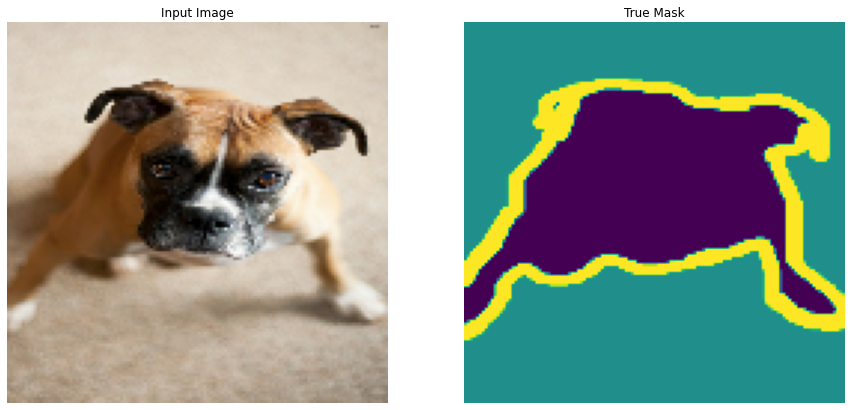

In [12]:
#------------------------------ Plot random images and respective true mask -----------------------------------#
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

from PIL import Image

i = 0
for images, masks in train_batches.take(1):
  sample_mask = tf.keras.preprocessing.image.array_to_img(masks[0])
  sample_image = tf.keras.preprocessing.image.array_to_img(images[0])
  display([sample_image, sample_mask])

for image, mask in train_images.as_numpy_iterator():
  i = i + 1
  image_name = "dataset/oxford_train/images/image_" + str(i) + '.png'
  label_name = "dataset/oxford_train/labels/image_" + str(i) + '.png'
  #cv2.imwrite(image_name, image)
  #cv2.imwrite(label_name, mask)
  break


In [13]:
i = 0
for image, mask in val_images.as_numpy_iterator():
  i = i + 1
  image_name = "dataset/oxford_test/images/image_" + str(i) + '.png'
  label_name = "dataset/oxford_test/labels/image_" + str(i) + '.png'
  cv2.imwrite(image_name, image)
  cv2.imwrite(label_name, mask)

Verifying training dataset


100%|██████████| 3680/3680 [00:20<00:00, 180.98it/s]
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 916s 2s/step - loss: 1.1903 - accuracy: 0.3878
saved  /tmp/vgg_unet_1.0
Epoch 2/5
512/512 [==============================] - 906s 2s/step - loss: 1.0188 - accuracy: 0.4382
saved  /tmp/vgg_unet_1.1
Epoch 3/5
512/512 [==============================] - 907s 2s/step - loss: 0.9547 - accuracy: 0.5213
saved  /tmp/vgg_unet_1.2
Epoch 4/5
512/512 [==============================] - 908s 2s/step - loss: 0.9230 - accuracy: 0.5699
saved  /tmp/vgg_unet_1.3
Epoch 5/5
512/512 [==============================] - 924s 2s/step - loss: 0.8961 - accuracy: 0.5899
saved  /tmp/vgg_unet_1.4


101it [01:31,  1.11it/s]

{'frequency_weighted_IU': 0.02236334290883396, 'mean_IU': 0.025611899637275334, 'class_wise_IU': array([0.00712106, 0.06440444, 0.0053102 ])}


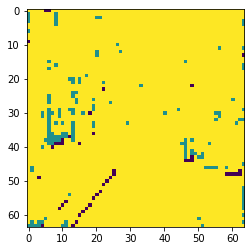

In [14]:
from keras_segmentation.models.unet import vgg_unet

#model = vgg_unet(n_classes=51 ,  input_height=416, input_width=608  )
model = vgg_unet(n_classes=3 ,  input_height=128, input_width=128  )

model.train(
    train_images =  "dataset/oxford_train/images/",
    train_annotations = "dataset/oxford_train/labels/",
    checkpoints_path = "/tmp/vgg_unet_1" , epochs=5
)

out = model.predict_segmentation(
    inp="dataset1/images_prepped_test/0016E5_07965.png",
    out_fname="/tmp/out.png"
)

import matplotlib.pyplot as plt
plt.imshow(out)

# evaluating the model 
print(model.evaluate_segmentation( inp_images_dir="dataset1/images_prepped_test/"  , annotations_dir="dataset1/annotations_prepped_test/" ) )

In [15]:
from keras_segmentation.models.model_utils import transfer_weights
from keras_segmentation.pretrained import pspnet_50_ADE_20K
from keras_segmentation.models.pspnet import pspnet_50

pretrained_model = pspnet_50_ADE_20K()

new_model = pspnet_50( n_classes=51 )

transfer_weights( pretrained_model , new_model  ) # transfer weights from pre-trained model to your model

new_model.train(
    train_images =  "dataset1/images_prepped_train/",
    train_annotations = "dataset1/annotations_prepped_train/",
    checkpoints_path = "/tmp/vgg_unet_1" , epochs=5
)

187842560/187839752 [==============================] - 3s 0us/step
Copying weights 


225it [00:00, 1143.31it/s]


Copied weights of 120 layers and skipped 1 layers
Verifying training dataset


100%|██████████| 367/367 [03:53<00:00,  1.57it/s]
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Dataset verified! 
Epoch 1/5
 41/512 [=>............................] - ETA: 5:50:40 - loss: 5.0213 - accuracy: 0.0089

KeyboardInterrupt: ignored

# **Evaluation**

Evaluate the model over the test dataset. We will use the last model weights and predict the class for some test images

In [ ]:
gc.collect
if args['evaluation_networks']:

  def show_image_prediction(loaded_model, n_images):
    #Try out the model on an image from the test data:
    #plt.figure(figsize=(30, 30))
    fig, axs = plt.subplots(1, n_images, figsize=(15, 15))
    fig.tight_layout(pad=1.0)

    # View the images
    for i in range(n_images):
        index = random.randint(0, len(x_test))
        image = x_test[index].squeeze()
        true_index = [i for i in range(nr_classes) if y_test[index][i] == 1 ][0]

        prediction_scores = loaded_model.predict(np.expand_dims(image, axis=0))
        predicted_index = np.argmax(prediction_scores)

        #image = np.add(image*128,128).astype(int)
        axs[i].imshow(image)
        axs[i].set_title("True Label = {0}, \n Predicted label = {1}".format(true_index, predicted_index))
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    
    plt.show()
    plt.close()

  #------------------------------ Predict on some test images -----------------------------------#
  i=1

  for network in args['compare_networks']:
      print("----------------------- model {} -----------------------".format(network))


      #plt.subplot(1, len(args['networks']), i)
      #Load last model parameters
      last_model_file = '{}/last_{}.h5'.format(args['models_dir'], network)
      best_model_file = '{}/best_{}.h5'.format(args['models_dir'], network)
      model_file = '{}/model_{}.h5'.format(args['models_dir'], network)

      #Load the model
      loaded_model = load_model(model_file)
      print("Loaded model {} from disk".format(model_file))
      loaded_model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy']) 

      #Try out the model on an image from the test data:
      show_image_prediction(loaded_model,8)

      #------------------------------ Evaluate model on testing dataset -----------------------------------#
      #_, acc = loaded_model.evaluate(x_train, y_train, verbose=0)
      #print("Training accuracy of model {0} = {1}".format(loaded_model.name, acc))
      _, acc = loaded_model.evaluate(x_test, y_test, verbose=0)
      print("Testing accuracy of model {0} = {1}".format(loaded_model.name, acc)) 

      #------------------------------ Plot all model results -----------------------------------#
      # save plot to file
      filename = "accuracy_" + network + '_plot.png'
      im = cv2.imread(filename)
      plt.imshow(im)
      plt.title("Accuray Results of model {}".format(network))
      i = i + 1

      plt.show()
  plt.close()